# Loading model

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from model_settings import ms
root = Path().resolve().parent.parent
models_dir = os.path.join(Path().resolve(),'trained_models','trained_models')
models = [f for f in os.listdir(models_dir) if f.find('ipynb')==-1]
for i,m in enumerate(models):
    print(f"{i}     {m}")

0     .DS_Store
1     2024_10_27 08-05-24 Deep Neural Network asian options


In [2]:
model = models[1]
model_dir = os.path.join(models_dir,model)
model_files = [f for f in os.listdir(model_dir) if f.find('ipynb')==-1 and f.find('.html')==-1]
for i,m in enumerate(model_files):
    print(f"{i}     {m}")

0     2024_10_27 08-05-24 Deep Neural Network asian options insample.csv
1     2024_10_27 08-05-24 Deep Neural Network asian options outsample.csv
2     2024_10_27 08-05-24 Deep Neural Network asian options.pkl
3     2024_10_27 08-05-24 Deep Neural Network asian options.txt


In [3]:
train_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f.find('insample')!=-1][0])).iloc[:,1:].copy()
test_data = pd.read_csv(os.path.join(model_dir,[f for f in model_files if f. find('outsample')!=-1][0])).iloc[:,1:].copy()
train_data['calculation_date'] = pd.to_datetime(train_data['calculation_date'])
test_data['calculation_date'] = pd.to_datetime(test_data['calculation_date'])
train_data = train_data.set_index('calculation_date')
test_data = test_data.set_index('calculation_date')
model_fit = joblib.load(os.path.join(model_dir,[f for f in model_files if f.endswith('.pkl')][0]))
print('maturities:',np.sort(test_data['days_to_maturity'].unique()))
print(model_fit)

maturities: [  1   7  28  84 168 336]
TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('StandardScaler',
                                                                                       StandardScaler(),
                                                                                       ['spot_price',
                                                                                        'strike_price',
                                                                                        'days_to_maturity',
                                                                                        'risk_free_rate',
                                                                                        'dividend_rate',
                                                                                        'kappa',
                                                            

In [4]:
# train_spots = train_data['spot_price']
# test_spots = test_data['spot_price']
# train_dates = pd.Series(train_spots.index)
# test_dates = pd.Series(test_spots.index)
# plt.figure()
# plt.plot(train_spots,color='green',label='development')
# plt.plot(test_spots,color='purple',label='out-of-sample')
# plt.title('available data')
# plt.ylabel('underlying spot price')
# plt.xticks(rotation=45)
# plt.legend()
# plt.show()
# print(test_data.shape[0])

In [5]:
# diff = test_data['outofsample_error'].copy()
def compute_RMSE(diff):
    if len(diff)>0:
        return np.sqrt(np.mean(diff.values**2))
        
def compute_MAE(diff):
    if len(diff)>0:
        return np.mean(np.abs(diff.values))

reg_cols = ['kappa','theta','rho','eta','v0','spot_price','RMSE','MAE']

plotcols = ['v0','RMSE', 'MAE','spot_price']

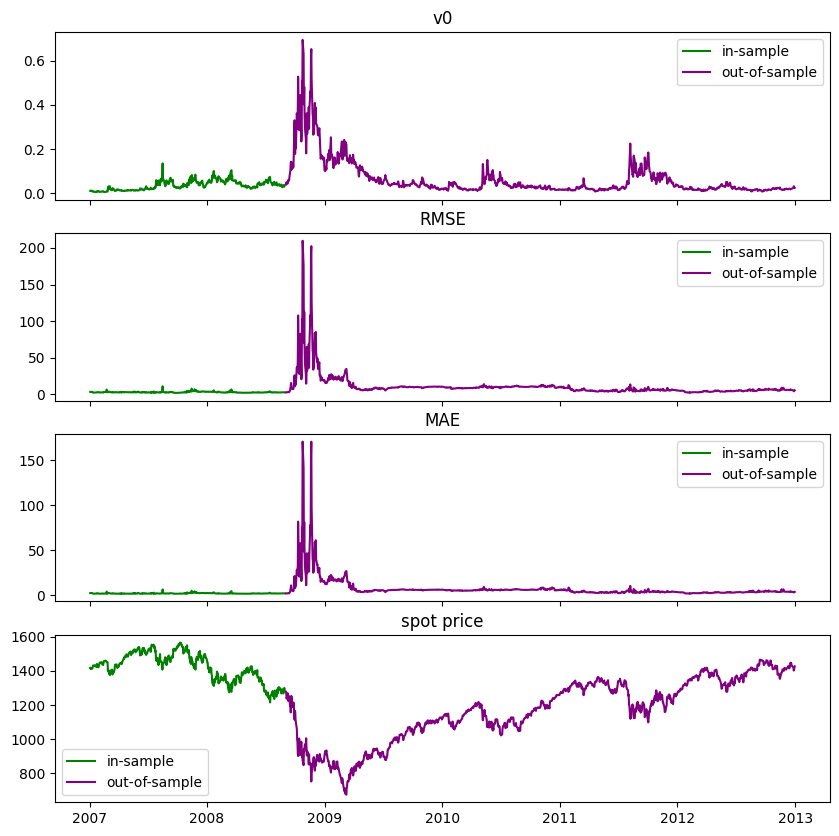

In [6]:
test_diff = test_data['outofsample_error']
train_diff = train_data['insample_error']



test_data['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
test_data['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
test_plot = test_data[reg_cols].copy().drop_duplicates()

train_data['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
train_data['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
train_plot = train_data[reg_cols].copy().drop_duplicates()

fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
for i,col in enumerate(plotcols):
    axs[i].plot(train_plot[col],color='green',label='in-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
for i,col in enumerate(plotcols):
    axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
plt.show()

# Testing

In [7]:
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
regression_data = test_plot

### testing for the effect of the spot level on pricing accuracy

In [8]:
regression_data.dtypes

kappa         float64
theta         float64
rho           float64
eta           float64
v0            float64
spot_price    float64
RMSE          float64
MAE           float64
dtype: object

### unrestricted regression

In [9]:
train_data

,spot_price,strike_price,days_to_maturity,n_fixings,fixing_frequency,past_fixings,averaging_type,w,risk_free_rate,dividend_rate,...,rho,eta,v0,asian,observed_price,insample_target,insample_prediction,insample_error,RMSE,MAE
calculation_date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,1416.59,708.0,7,7.0,1,0,geometric,call,0.04,0.018125,...,-1.0,0.098497,0.010662,708.565704,708.560092,708.560092,706.871458,-1.688634,3.433454,2.206076
2007-01-03,1416.59,1062.0,336,2.0,168,0,arithmetic,call,0.04,0.018125,...,-1.0,0.098497,0.010662,355.612999,355.621112,355.621112,354.294880,-1.326232,3.433454,2.206076
2007-01-03,1416.59,1062.0,336,2.0,168,0,geometric,put,0.04,0.018125,...,-1.0,0.098497,0.010662,0.021733,0.005171,0.005171,0.676421,0.671250,3.433454,2.206076
2007-01-03,1416.59,1062.0,336,2.0,168,0,geometric,call,0.04,0.018125,...,-1.0,0.098497,0.010662,353.743519,353.712116,353.712116,352.303374,-1.408743,3.433454,2.206076
2007-01-03,1416.59,708.0,336,2.0,168,0,arithmetic,put,0.04,0.018125,...,-1.0,0.098497,0.010662,0.000000,0.017501,0.017501,3.439501,3.422001,3.433454,2.206076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-08-29,1283.32,1924.0,168,168.0,1,0,geometric,put,0.04,0.022617,...,-1.0,0.170760,0.034935,619.555013,619.567878,619.567878,618.762774,-0.805104,2.769549,1.801337
2008-08-29,1283.32,1924.0,168,168.0,1,0,arithmetic,call,0.04,0.022617,...,-1.0,0.170760,0.034935,0.001285,0.004985,0.004985,0.000000,-0.004985,2.769549,1.801337
2008-08-29,1283.32,1924.0,168,168.0,1,0,arithmetic,put,0.04,0.022617,...,-1.0,0.170760,0.034935,619.555013,619.568313,619.568313,616.821376,-2.746937,2.769549,1.801337


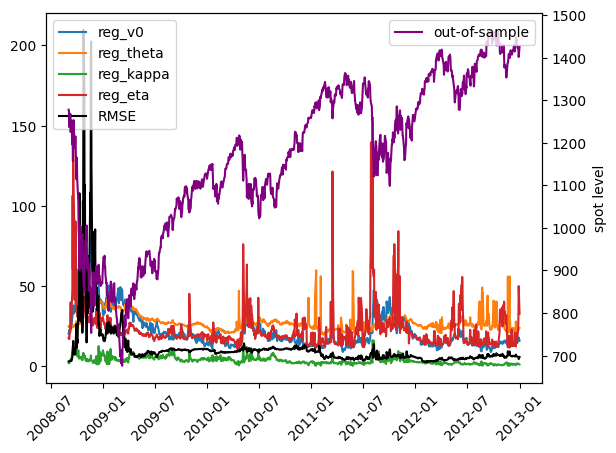

In [10]:
X = pd.DataFrame()
X['reg_s'] = regression_data['spot_price']
X['reg_v0'] = np.sqrt(regression_data['v0'])*100 
X['reg_theta'] = np.sqrt(regression_data['theta'])*100 
X['reg_kappa'] = regression_data['kappa']
X['reg_eta'] = regression_data['eta']*100

target_name = 'RMSE'
y = regression_data[target_name].loc[X.index]
fit_intercept = False

fig, ax1 = plt.subplots()
plt.xticks(rotation=45)
ax2 = ax1.twinx()
for column in X.columns[1:]:
    ax1.plot(X.index, X[column], label=column)
ax1.plot(X.index, y, label=target_name, color="black")
ax2.plot(X.index, X['reg_s'], label='out-of-sample', color="purple")
ax2.set_ylabel("spot level")
ax1.legend(loc='upper left')
ax2.legend(loc="upper right")
plt.show()

In [11]:
Ufit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Uyhat = Ufit.predict(X)
URSS = sum((Uyhat-y)**2)
for i,c in enumerate(Ufit.coef_):
    print(f"{X.columns[i].replace('reg_','')} - b{i}:  {c}")
print(f"intercept: {Ufit.intercept_}")
print(f"R Squared: {Ufit.score(X,y)}")
print(f"\nURSS: {URSS}")

s - b0:  0.0003174647059572703
v0 - b1:  1.2249614964602502
theta - b2:  -0.34245424864156937
kappa - b3:  -1.3233345123854439
eta - b4:  -0.11117900572889783
intercept: 0.0
R Squared: 0.5579204179162969

URSS: 130850.98430341936


### restricted regression

In [12]:
X = X.iloc[:,1:].copy()
Rfit = LinearRegression(fit_intercept=fit_intercept).fit(X,y)
Ryhat = Rfit.predict(X)
RRSS = sum((Ryhat-y)**2)
for i,c in enumerate(Rfit.coef_):
    print(f"{X.columns[i].replace('reg_','')} - b{i}:  {c}")
print(f"intercept: {Rfit.intercept_}")
print(f"R Squared: {Rfit.score(X,y)}")
print(f"\nRRSS: {RRSS}")

v0 - b0:  1.2185514516041211
theta - b1:  -0.32658057513591515
kappa - b2:  -1.3290971797124078
eta - b3:  -0.10736978783087447
intercept: 0.0
R Squared: 0.5578913500480231

RRSS: 130859.58809180807


### F-Test

In [13]:
m = len(Ufit.coef_)-len(Rfit.coef_)
n = len(y)
k = len(Ufit.coef_)
dfn = m
dfd = n-k-1
F = ((RRSS-URSS)/dfn)/(URSS/dfd)
alpha = 0.05
critF = stats.f.ppf(1 - alpha, dfn=dfn, dfd=dfd)
print(f"F: {F}, Critical F: {critF}")

F: 0.07134153748585685, Critical F: 3.850043646752174


In [14]:
for col in X.columns:
    regression_data[col] = X[col]
regression_data['y'] = y
regression_data['Uyhat'] = Uyhat
regression_data['Ryhat'] = Ryhat
regression_data

,kappa,theta,rho,eta,v0,spot_price,RMSE,MAE,reg_v0,reg_theta,reg_kappa,reg_eta,y,Uyhat,Ryhat
calculation_date,,,,,,,,,,,,,,,
2008-09-02,2.129509,0.060409,-1.000000,0.172868,0.040641,1277.53,2.757522,1.789542,20.159720,24.578213,2.129509,17.286782,2.757522,11.943558,11.852487
2008-09-03,2.693908,0.058609,-1.000000,0.178095,0.038360,1275.25,2.810832,1.781569,19.585714,24.209285,2.693908,17.809461,2.810832,10.561041,10.467255
2008-09-04,1.521139,0.062183,-1.000000,0.167885,0.050277,1236.81,2.844644,1.781019,22.422504,24.936516,1.521139,16.788463,2.844644,15.440231,15.354877
2008-09-05,2.859490,0.059311,-1.000000,0.183520,0.044849,1242.38,2.865858,1.795580,21.177557,24.353805,2.859490,18.351988,2.865858,12.171622,12.081474
2008-09-08,3.372719,0.055250,-0.735338,0.256952,0.043867,1267.76,2.994667,1.907757,20.944396,23.505214,3.372719,25.695196,2.994667,10.689085,10.603919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-24,1.533653,0.045075,-0.758727,0.187296,0.021678,1425.78,5.811224,3.491105,14.723486,21.230839,1.533653,18.729596,5.811224,7.105873,6.958378
2012-12-26,1.502570,0.045965,-0.631430,0.230292,0.024230,1419.95,5.515436,3.396736,15.566046,21.439524,1.502570,23.029183,5.515436,7.627771,7.496596
2012-12-27,1.254997,0.049897,-0.471477,0.306944,0.026584,1417.38,5.195527,3.311010,16.304571,22.337609,1.254997,30.694357,5.195527,7.699482,7.609270


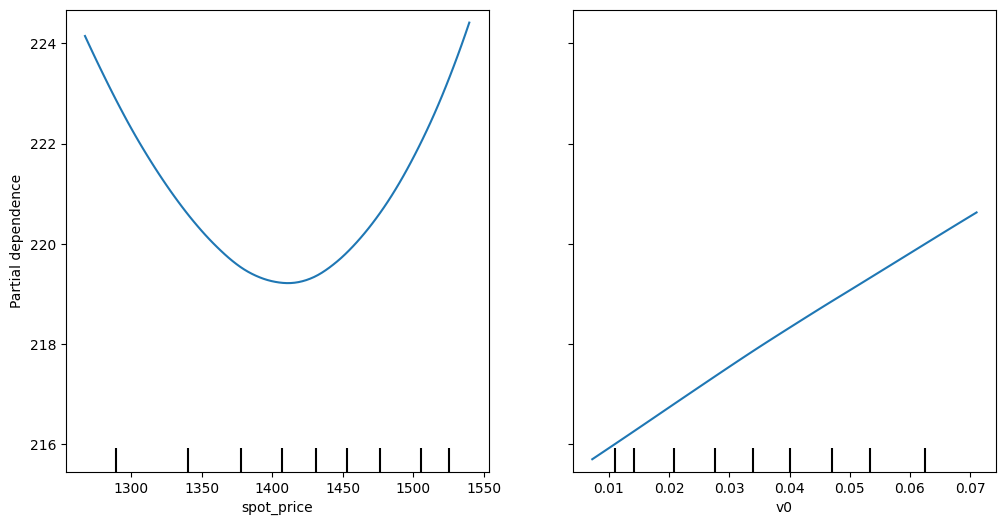

In [15]:
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
part_disp_X = train_data[model_fit.feature_names_in_]
fig, ax = plt.subplots(figsize=(12, 6))
disp = PartialDependenceDisplay.from_estimator(model_fit, part_disp_X, ["spot_price", "v0"], ax=ax)

In [16]:
new_train = pd.concat([train_data,test_data[test_data.index<=pd.Timestamp(2009,4,1)]],ignore_index=False).dropna(how='any',axis=1).reset_index(drop=False).copy()
new_test = test_data[~test_data.index.isin(new_train['calculation_date'])].copy().reset_index()
from convsklearn import asian_trainer
trainer = asian_trainer
arrs = trainer.get_train_test_arrays(new_train, new_test)
train_X = arrs['train_X']
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
preprocessor = trainer.preprocess()
retrained_model, runtime, specs = trainer.run_dnn(preprocessor,train_X,train_y)
insample, outsample, errors = trainer.test_prediction_accuracy(retrained_model,new_test,new_train)
outsample = outsample.set_index('calculation_date')
insample = insample.set_index('calculation_date')


training...

Deep Neural Network
hidden layers sizes: (15, 15, 15)
learning rate: adaptive
activation: relu
solver: sgd
alpha: 0.0001

in sample:
     RMSE: 11.532122804015824
     MAE: 7.762235790163984

out of sample:
     RMSE: 18.511412362521305
     MAE: 11.75408156589009


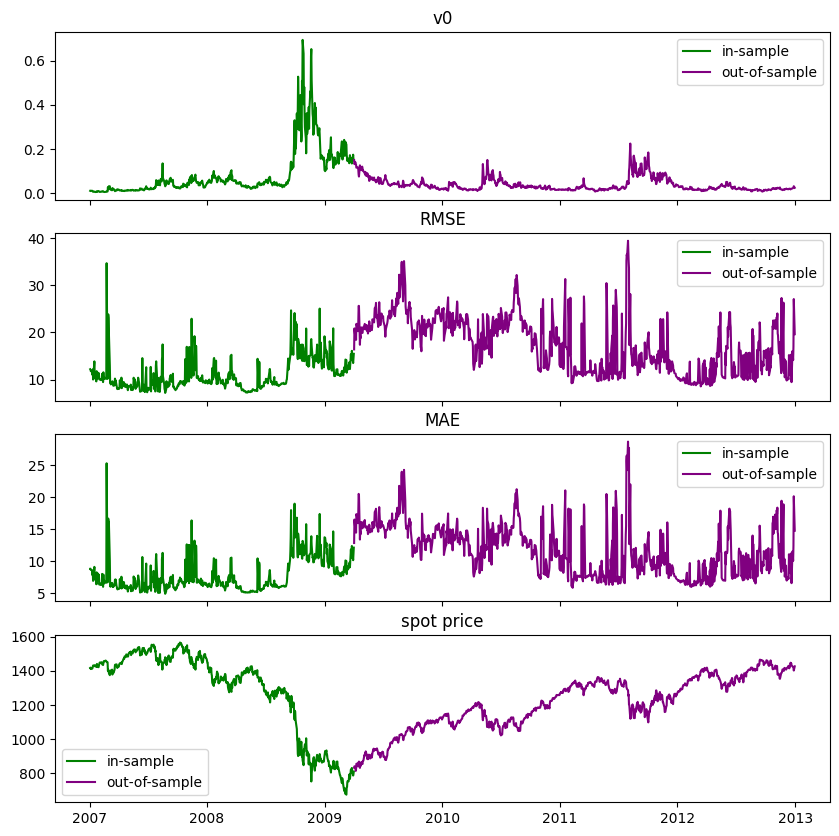

In [17]:
test_diff = outsample['outofsample_error']
train_diff = insample['insample_error']

plotcols = ['v0','RMSE', 'MAE','spot_price']


outsample['RMSE'] = test_diff.resample('D').apply(compute_RMSE).dropna()
outsample['MAE'] = test_diff.resample('D').apply(compute_MAE).dropna()
test_plot = outsample[plotcols].copy().drop_duplicates()

insample['RMSE'] = train_diff.resample('D').apply(compute_RMSE).dropna()
insample['MAE'] = train_diff.resample('D').apply(compute_MAE).dropna()
train_plot = insample[plotcols].copy().drop_duplicates()

fig,axs = plt.subplots(len(plotcols),figsize=(10,10),sharex=True)
for i,col in enumerate(plotcols):
    axs[i].plot(train_plot[col],color='green',label='in-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
for i,col in enumerate(plotcols):
    axs[i].plot(test_plot[col],color='purple',label='out-of-sample')
    axs[i].set_title(col.replace('_',' '))
    axs[i].legend()
plt.show()